In [28]:
import os
import sktime
from sktime.datasets import load_from_tsfile_to_dataframe
import tslearn
# from tslearn.clustering import TimeSeriesKMeans
# from tslearn.preprocessing import TimeSeriesScalerMeanVariance
# from tslearn.preprocessing import TimeSeriesResampler
import matplotlib.pyplot as plt
import numpy as np
import signatory
import torch
import mean_pennec
import mean_le
import mean_pathopt
import utils
import pandas as pd
import time
from matplotlib import cm
from matplotlib.lines import Line2D

In [29]:
X_train, y_train = load_from_tsfile_to_dataframe("./data/PenDigits/PenDigits_TRAIN.ts")
X_test, y_test = load_from_tsfile_to_dataframe("./data/PenDigits/PenDigits_TEST.ts")

X = pd.concat([X_train, X_test], ignore_index=True)
y_true = np.concatenate((y_train, y_test))
# np.unique(y_true, return_counts=True)
# **Remark.** Each class represent an equal proportion of the data.
X = X.to_numpy()
batch = X.shape[0]
stream = len(X[0,0])
channels = X.shape[1]
Xtemp = np.empty((batch, stream, channels))
for obs in range(batch):
    for channel in range(channels):
        Xtemp[obs, :, channel] = X[obs, channel]
Xtemp = torch.from_numpy(Xtemp)
X = Xtemp

In [30]:
# **STEP 1.** NORMALIZATION of dataset of paths `X`
print(X[1])
X = utils.datascaling(X)
print(X[1])

tensor([[  0.,  89.],
        [ 27., 100.],
        [ 42.,  75.],
        [ 29.,  45.],
        [ 15.,  15.],
        [ 37.,   0.],
        [ 69.,   2.],
        [100.,   6.]], dtype=torch.float64)
tensor([[0.0000, 0.4158],
        [0.1261, 0.4672],
        [0.1962, 0.3504],
        [0.1355, 0.2102],
        [0.0701, 0.0701],
        [0.1729, 0.0000],
        [0.3223, 0.0093],
        [0.4672, 0.0280]], dtype=torch.float64)


In [31]:
# STEP 1.2  SHIFT THE DATA 
print(X[1])
X = utils.datashift(X)
print(X[1])

tensor([[0.0000, 0.4158],
        [0.1261, 0.4672],
        [0.1962, 0.3504],
        [0.1355, 0.2102],
        [0.0701, 0.0701],
        [0.1729, 0.0000],
        [0.3223, 0.0093],
        [0.4672, 0.0280]], dtype=torch.float64)
tensor([[ 0.0000,  0.0000],
        [ 0.1261,  0.0514],
        [ 0.1962, -0.0654],
        [ 0.1355, -0.2056],
        [ 0.0701, -0.3457],
        [ 0.1729, -0.4158],
        [ 0.3223, -0.4064],
        [ 0.4672, -0.3877]], dtype=torch.float64)


In [5]:
depth = 5
SX = signatory.signature(X, depth=depth)

In [6]:
def kmeans(k, signatures, depth, channels, max_iterations, seed,
           mean_strat='PE', dist='l2', verbose=False):
    """
    Perform k-means on a dataset of signatures.

    Parameters
    ----------
    max_iterations : int
                     number of iterations before k-means stops
    dist : string
           Distance to use. One of 'l2', 'sigdist'.
    mean_strat : string
                 Strategy to use for averaging. One of 'PE', 'LE'.

    Notes
    -----
    Cluster associated to each observation for every k-means iteration is
    written in the logs folder.
    """
    batch, siglen = signatures.shape
    y_pred = -1*np.ones(batch, dtype='int')  # corresponding cluster index for each obs
    with open(logsfilename, 'w') as the_file:
        the_file.write('')

    # INITIALIZATION
    # choose k obs randomly to start from
    rng = np.random.default_rng(seed)
    idx_init_centroid = rng.integers(batch, size=k)
    # # not random initialization
    # idx_init_centroid = [7, 2, 1, 15, 3, 8, 5, 14, 0, 10]
    centroids = signatures[idx_init_centroid]

    for iteration in range(max_iterations):
        # if iteration%5==0:
        print(f"iteration #{iteration}")
        # ASSIGN OBS TO CLUSTER W/ NEAREST CENTROID
        for idx, sig in enumerate(signatures):
            if dist=='l2':
                distlist = [torch.norm(sig-centroids[i]) for i in range(k)]  # L2 DISTANCE
            elif dist=="sigdist":
                distlist = [utils.dist_on_sigs(sig, centroids[i], depth, channels) for i in range(k)]  # SIG DISTANCE
            id_cluster = np.argmin(distlist)
            y_pred[idx] = id_cluster
        # UPDATE MEAN VALUES TO MEAN OF CLUSTER
        # sum1 = 0
        for i in range(k):
            to_average = signatures[y_pred==i, :]  # select obs of cluster i
            # sum1 += to_average.shape[0]
            if not len(to_average)==0:
                if mean_strat=='PE':
                    centroids[i] = mean_pennec.mean(to_average, depth, channels)
                elif mean_strat=='LE':
                    centroids[i] = mean_le.mean(to_average, depth, channels)
                else:
                    return("Chosen mean strategy do NOT exist.")
        if verbose:
            # print(f"SUM  = {sum1}")
            print(f"first cluster indices : {y_pred[:15]}")
            print(f"mean values")
            print((centroids[0])[14:24])
            print((centroids[3])[14:24])
            print((centroids[6])[14:24])
        with open(logsfilename, 'a') as the_file:
            the_file.write(f'{list(y_pred)}\n')
    return(y_pred)

In [24]:
intracluster = {}
for key in range(10):
    intracluster[key] = 0.2

In [25]:
intracluster.values()

dict_values([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2])

In [27]:
sum(intracluster.values())

1.9999999999999998

In [5]:
d[3] = []
d.keys()

dict_keys([3])

In [3]:
d

{3: []}

# PLOTTING

In [7]:
SX.shape

torch.Size([10992, 62])

In [8]:
nclasses = 10
digits = np.array([str(i) for i in range(nclasses)])
print(digits)
colors = [plt.cm.tab10(i) for i in range(nclasses)]

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [9]:
# COMPUTATION OF PATHOPT MEAN IN EACH CLASS
paths_by_digit = {}
for digit in digits:
    paths_by_digit[digit] = X[y_true==f'{digit}']

In [15]:
sigbarycenterPO = {}

ninit = 3

for digit in digits:
    to_average = paths_by_digit[digit]
    barycenters = mean_pathopt.mean(to_average, depth, n_init=ninit, init_len=5, niter=200)
    print(barycenters[0].shape)
    barycenters = [bary.unsqueeze(0) for bary in barycenters]
    print(barycenters[0].shape)
    databarycenters = torch.cat(barycenters, dim=0)
    print(databarycenters.shape)
    
    Smeanspathopt = signatory.signature(databarycenters, depth)
    Smeanspathopt_scaled = Smeanspathopt.clone()
    for sig in Smeanspathopt_scaled:
        sig = utils.sigscaling(sig, depth, channels)
    Smeanspathopt = Smeanspathopt_scaled
    sigbarycenterPO[digit] = Smeanspathopt

Terminated - max iterations reached after 18.41 seconds.

Multistart: initialization #1 / 3 terminated.
Terminated - max iterations reached after 18.16 seconds.

Multistart: initialization #2 / 3 terminated.
Terminated - max iterations reached after 17.81 seconds.

Multistart: initialization #3 / 3 terminated.
torch.Size([5, 2])
torch.Size([1, 5, 2])
torch.Size([3, 5, 2])
Terminated - max iterations reached after 18.61 seconds.

Multistart: initialization #1 / 3 terminated.
Terminated - max iterations reached after 18.19 seconds.

Multistart: initialization #2 / 3 terminated.
Terminated - max iterations reached after 18.55 seconds.

Multistart: initialization #3 / 3 terminated.
torch.Size([5, 2])
torch.Size([1, 5, 2])
torch.Size([3, 5, 2])
Terminated - max iterations reached after 18.05 seconds.

Multistart: initialization #1 / 3 terminated.
Terminated - max iterations reached after 18.13 seconds.

Multistart: initialization #2 / 3 terminated.
Terminated - max iterations reached after 

In [11]:
# STEP 2 . NORMALIZATION OF THE SIGNATURE RESP. TO EACH ORDER
SXscaled = SX.clone()
print(SXscaled[0,12])
for sig in SXscaled:
    sig = utils.sigscaling(sig, depth, channels)
print(SXscaled[0,12])

tensor(-0.0013, dtype=torch.float64)
tensor(-0.0075, dtype=torch.float64)


In [12]:
sigs_by_digit = {}
for digit in digits:
    sigs = SXscaled[y_true==f'{digit}']
    sigs_by_digit[digit] = sigs

In [13]:
# NOT USING SXscaled but SX

sigbarycenterPE = {}
sigbarycenterLE = {}
for digit in digits:
    sigs = SX[y_true==f'{digit}']
    meanP = mean_pennec.mean(sigs, depth, channels)
    meanPscaled = utils.sigscaling(meanP, depth, channels)
    sigbarycenterPE[digit] = meanPscaled
    meanLE = mean_le.mean(sigs, depth, channels)
    meanLEscaled = utils.sigscaling(meanLE, depth, channels)
    sigbarycenterLE[digit] = meanLEscaled

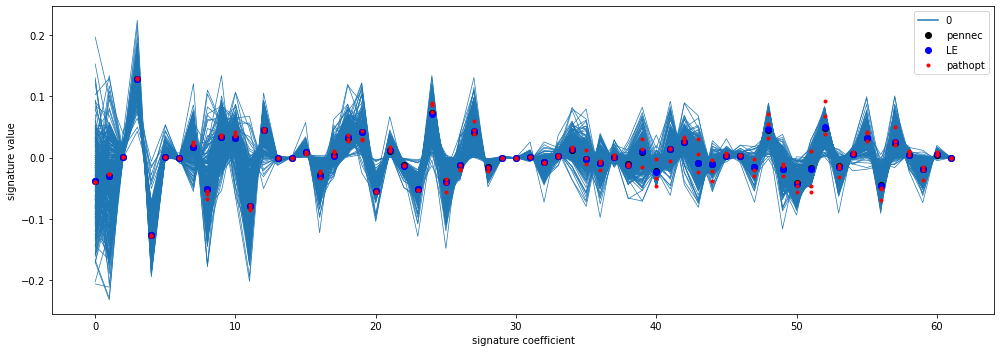

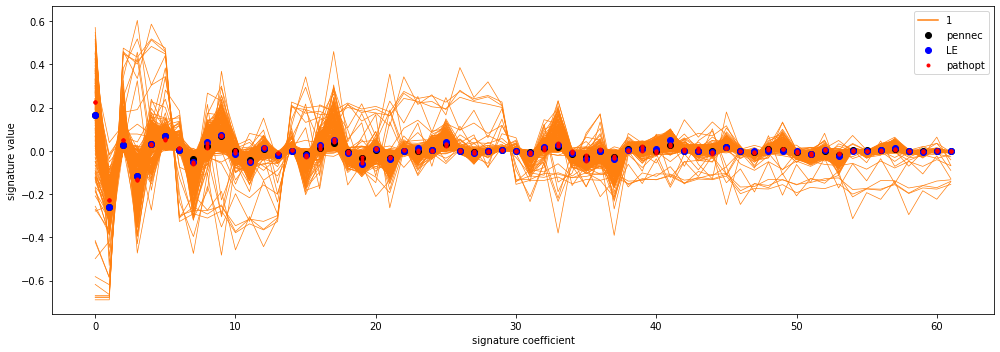

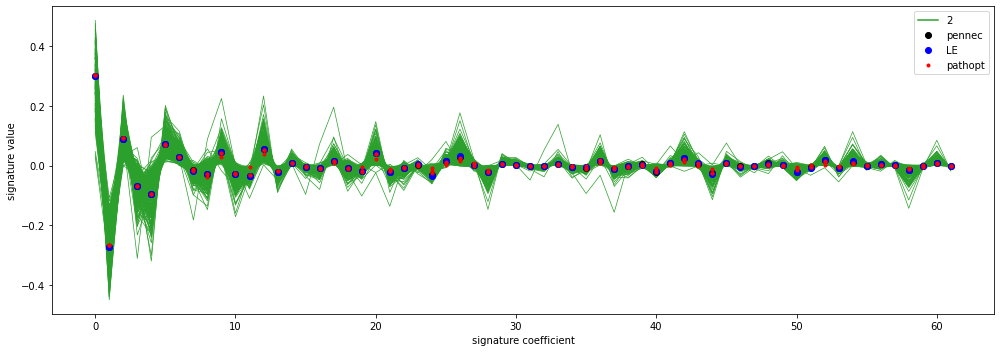

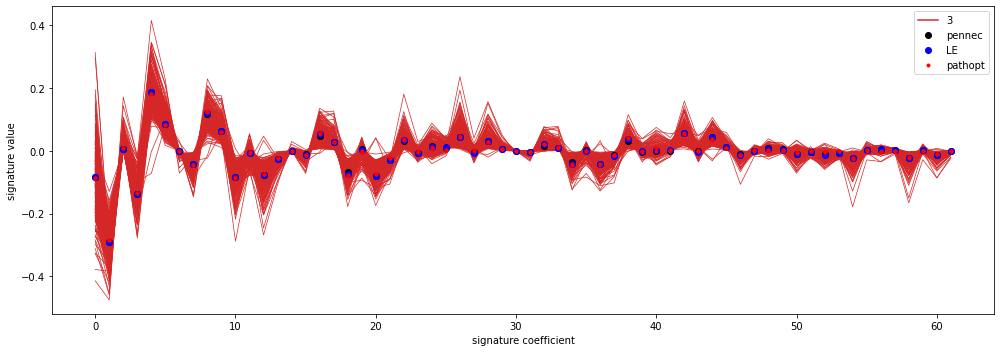

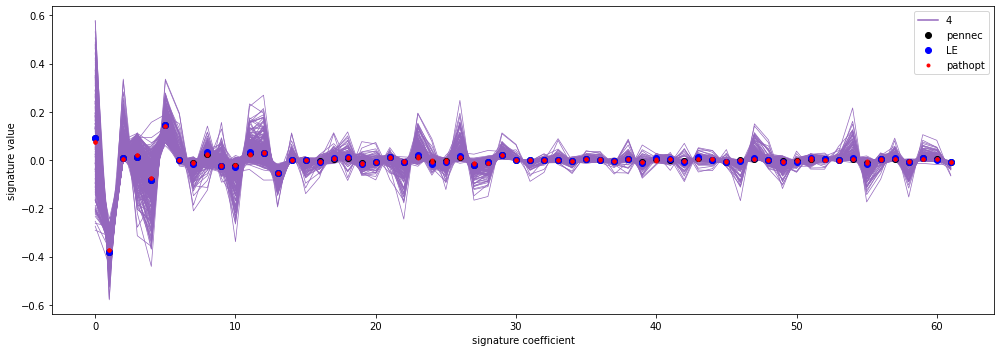

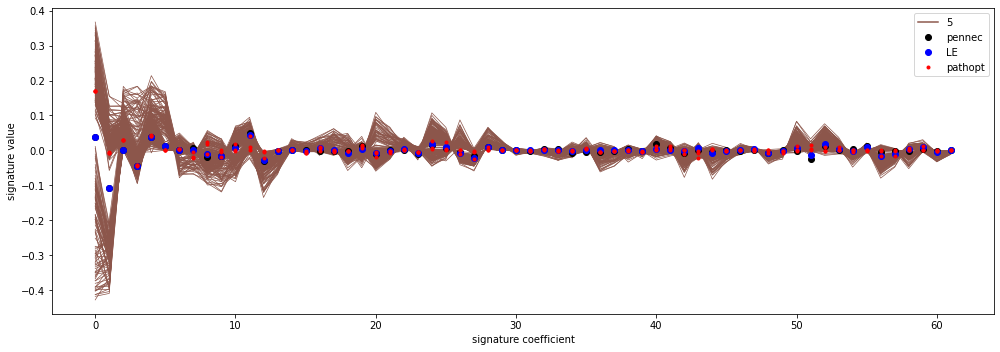

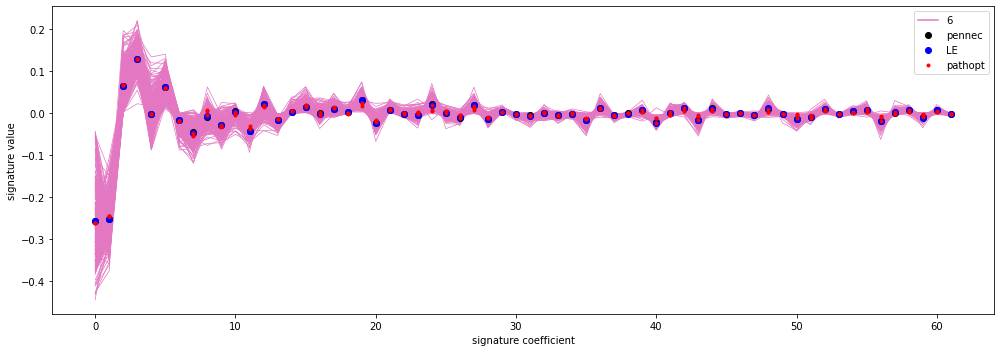

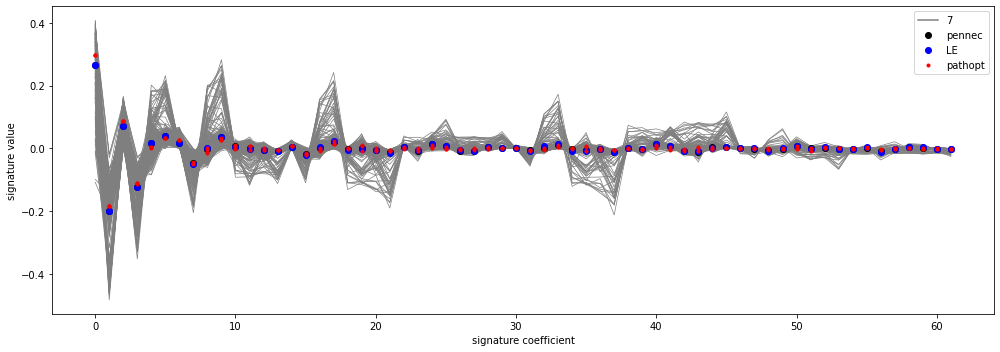

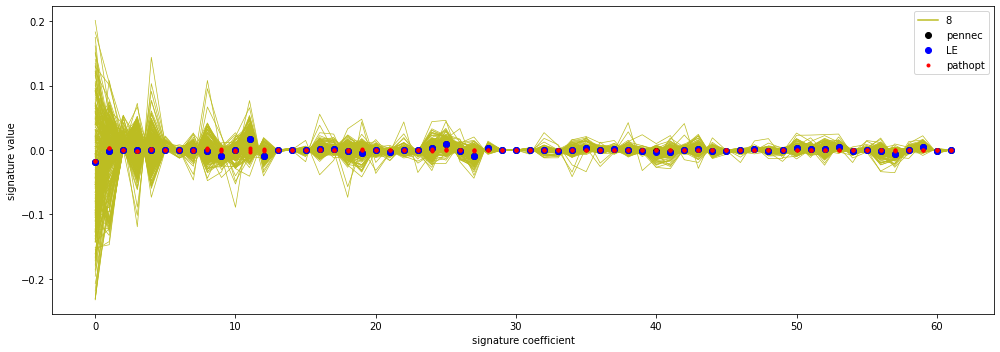

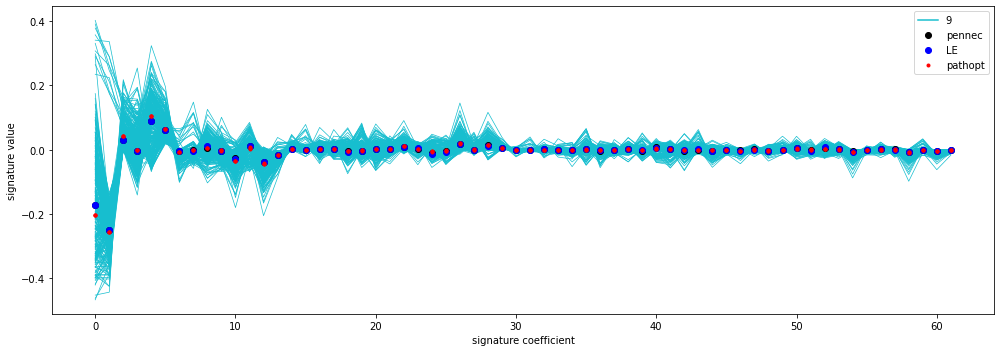

In [14]:
maxtoplot = 100
for i in range(nclasses): #nclasses
    plt.figure(figsize=(14,5))
    digittoshow = [i]
    # plt.subplot(10,1,i+1)
    for digit in digittoshow:
        strdigit = str(digit)
        for idx_obs in range(maxtoplot):
            sig = sigs_by_digit[strdigit][idx_obs, :]
            plt.plot(sig, color=colors[digit], linewidth=0.7)
        plt.plot(sigbarycenterPE[strdigit], 'ko')
        plt.plot(sigbarycenterLE[strdigit], 'bo')
        for sig in sigbarycenterPO[strdigit]: 
            plt.plot(sig, 'ro', markersize=3)
    custom = [Line2D([0], [0], color=colors[i]) for i in digittoshow]
    custom.append(Line2D([], [], color='k', marker='o', linestyle='None'))
    custom.append(Line2D([], [], color='b', marker='o', linestyle='None'))
    custom.append(Line2D([], [], color='r', marker='o', markersize=3, linestyle='None'))
    labels = digittoshow + ['pennec', 'LE', 'pathopt']
    plt.legend(custom, labels)
    plt.ylabel("signature value")
    plt.xlabel("signature coefficient")
    plt.tight_layout()
    timestr = time.strftime("%Y%m%d_%H%M%S")
    plt.savefig(f"./img/clustering/pendigits/barycenters_comparison_digit{i}_{timestr}", dpi=150)
plt.show()

In [85]:
print([2**k for k in range(6)])
print(np.cumsum([2**k for k in range(6)]))

[1, 2, 4, 8, 16, 32]
[ 1  3  7 15 31 63]


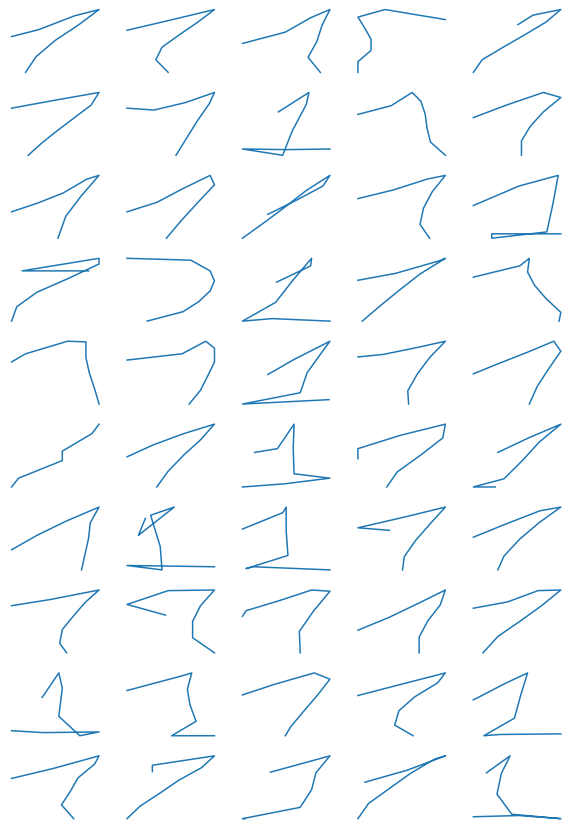

In [35]:
ones = X[y_true=='1']
plt.figure(figsize=(10, 15))
for idx, obs in enumerate(ones[:50]):
    plt.subplot(10,5,idx+1)
    plt.plot(obs[:, 0], obs[:, 1])
    plt.axis('off')
plt.show()

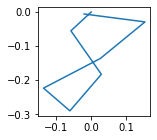

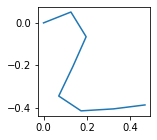

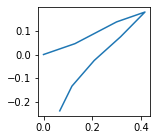

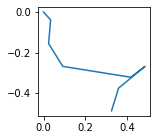

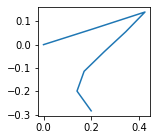

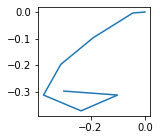

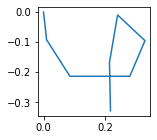

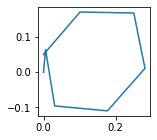

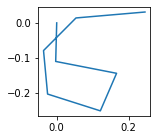

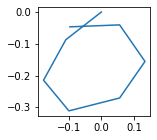

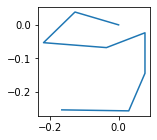

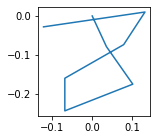

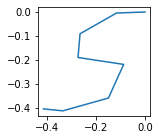

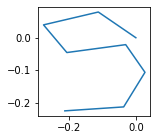

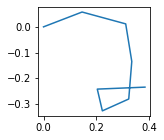

In [8]:
for obs in X[:15]:
    plt.figure(figsize=(2,2))
    plt.plot(obs[:, 0], obs[:, 1])

# k-means

In [7]:
start = time.time()
timestr = time.strftime("%Y%m%d_%H%M%S")
logsfilename = f'./logs/log_clusteridx_PE_{timestr}.txt'

### PARAMETERS TO SET FOR K-MEANS ALGORITHM ###################################

y = kmeans(k=10, signatures=SX, depth=depth, channels=channels,
           max_iterations=10, #10, 30
           dist='sigdist',
           seed=1555,
           mean_strat='PE')

###############################################################################


end = time.time()
dura = f"duration of algorithm : {np.around((end-start)/60, 2)} min\n"
with open(logsfilename, 'a') as the_file:
    the_file.write(dura)
print(dura)

iteration #0
iteration #1
iteration #2
iteration #3
iteration #4
iteration #5
iteration #6
iteration #7
iteration #8
iteration #9
duration of algorithm : 54.66 min



In [8]:
for i in range(10):
    output = np.unique(y[y_true==f'{i}'], return_counts=True)
    with open(logsfilename, 'a') as the_file:
        the_file.write(str(output)+'\n')

In [9]:
start = time.time()
timestr = time.strftime("%Y%m%d_%H%M%S")
logsfilename = f'./logs/log_clusteridx_LE_{timestr}.txt'

### PARAMETERS TO SET FOR K-MEANS ALGORITHM ###################################

y = kmeans(k=10, signatures=SX, depth=depth, channels=channels,
           max_iterations=10, #10, 30
           dist='sigdist',
           seed=1555,
           mean_strat='LE')

###############################################################################


end = time.time()
dura = f"duration of algorithm : {np.around((end-start)/60, 2)} min\n"
with open(logsfilename, 'a') as the_file:
    the_file.write(dura)
print(dura)

iteration #0
iteration #1
iteration #2
iteration #3
iteration #4
iteration #5
iteration #6
iteration #7
iteration #8
iteration #9
duration of algorithm : 32.3 min



In [10]:
for i in range(10):
    output = np.unique(y[y_true==f'{i}'], return_counts=True)
    with open(logsfilename, 'a') as the_file:
        the_file.write(str(output)+'\n')

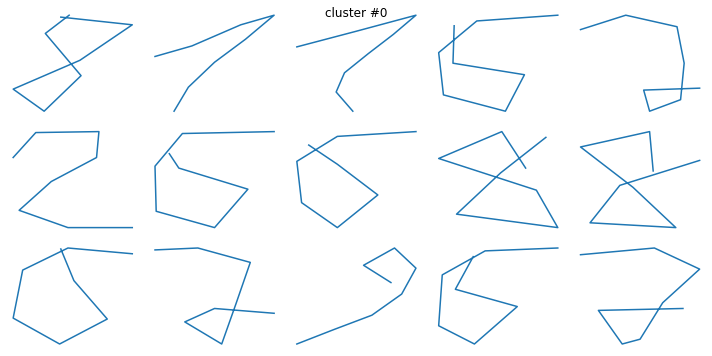

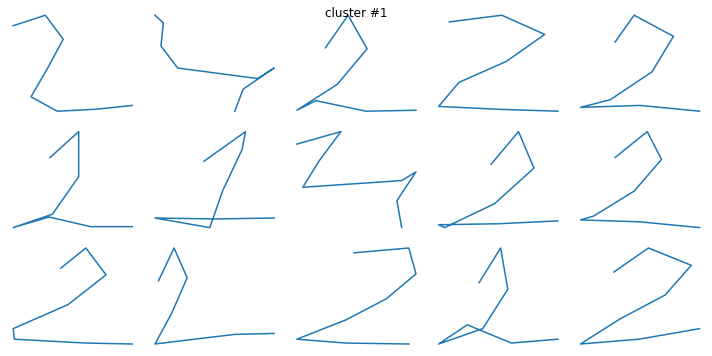

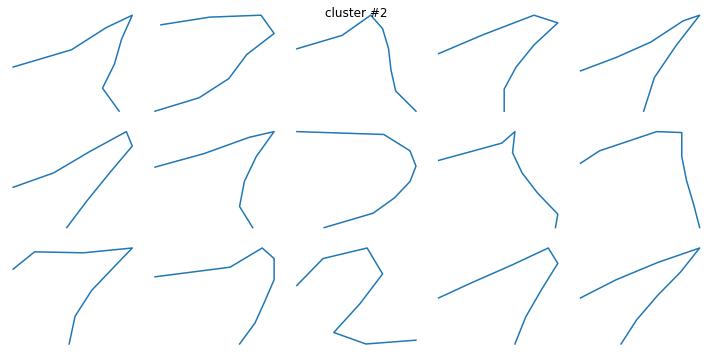

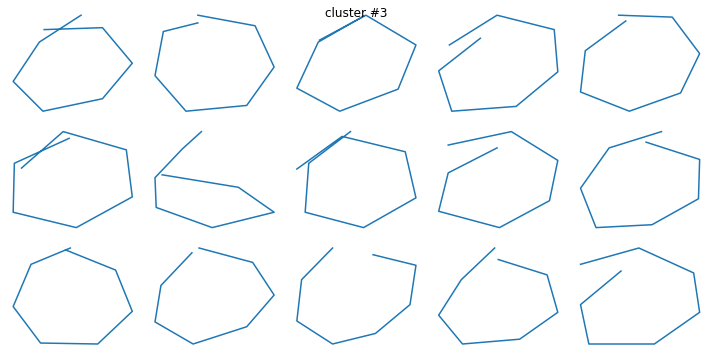

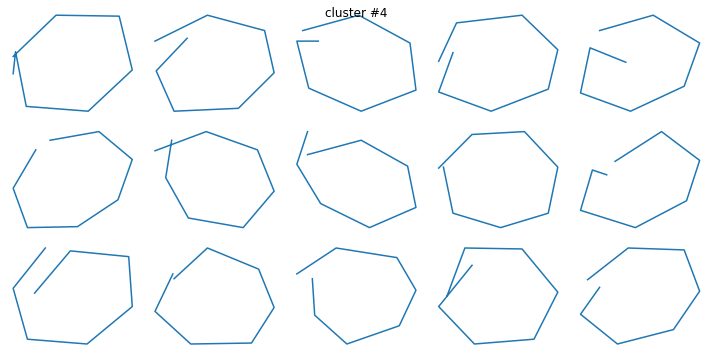

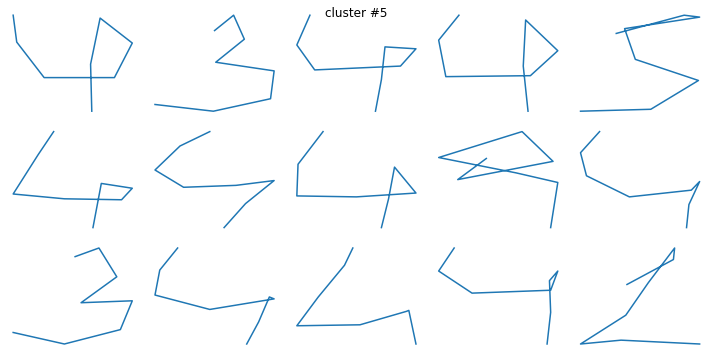

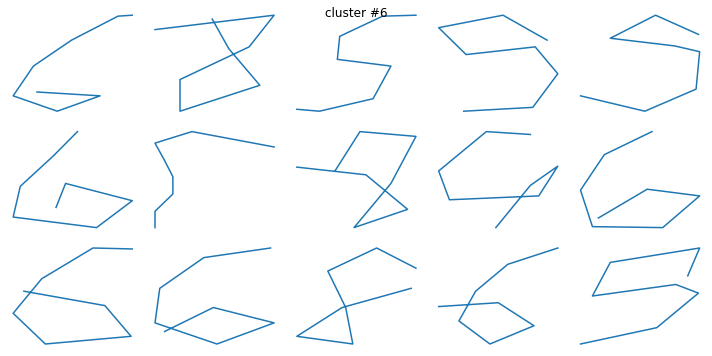

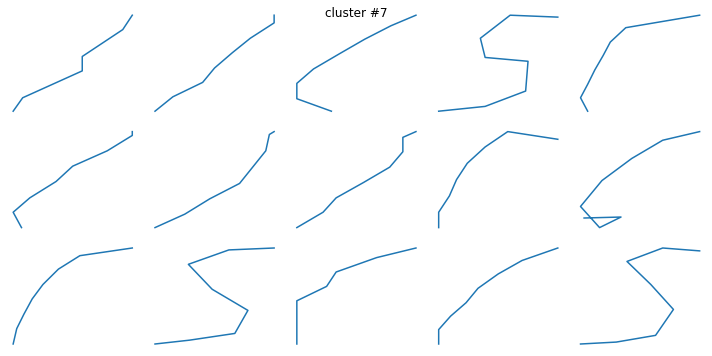

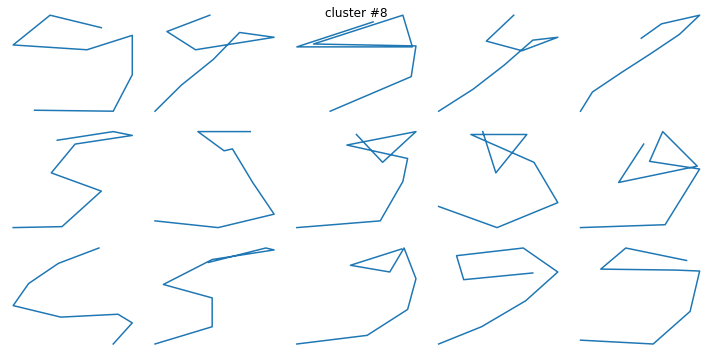

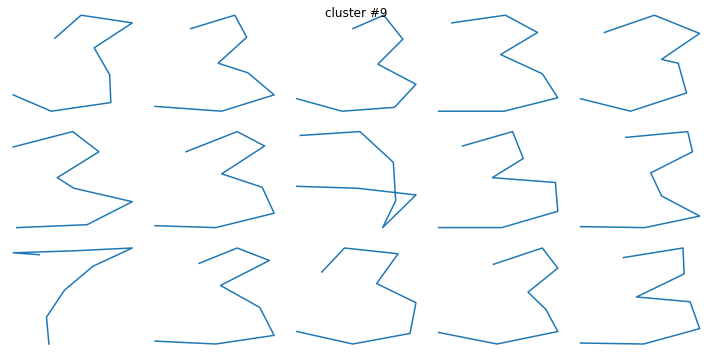

In [27]:
for i in range(10):
    cluster = X[y==i]
    plt.figure(figsize=(10,5))
    for j, obs in enumerate(cluster[:15]):
        plt.subplot(3,5,j+1)
        plt.axis('off')
        plt.plot(obs[:, 0], obs[:, 1])
    plt.tight_layout()
    plt.suptitle(f"cluster #{i}")
    plt.savefig(f"./img/clustering/pendigits/meanLEcluster{i}_{timestr}", dpi=150)

plt.show()